In [3]:
import sys
# # sys.path.append('/global/cscratch1/sd/jianyao/ForSE/')
sys.path.append('/pscratch/sd/j/jianyao/forse_codes/') 
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
# # sys.path.append('/pscratch/sd/j/jianyao/ForSE')
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import numpy as np

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [98]:
import pymaster as nmt
from astropy import units as u

In [5]:
import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

In [7]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import Reshape, Dense, Input
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
import numpy as np
import os
from tensorflow.keras import backend as K

import threading
from datetime import datetime
import time

In [55]:
from pipeline_evaluation_NN import *

# initialize the network 

In [74]:
img_shape = (320, 320, 1); kernel_size = 5; cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True); channels = 1;
def build_generator():
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", input_shape=img_shape)) # 64x64x64
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", strides=2)) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same", strides=2)) #16x16x256
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(channels, kernel_size=kernel_size, padding="same"))
    model.add(Activation("tanh"))
    # img_in = Input(shape=img_shape)
    # img_out = model(img_in)
    # return Model(img_in, img_out)
    return model

def build_discriminator():

    model = Sequential()
    model.add(Conv2D(64, kernel_size=kernel_size, strides=1, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Conv2D(256, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # img = Input(shape=img_shape)
    # validity = model(img)
    # return Model(img, validity)
    return model

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.00005, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00005, 0.5)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

# calculate the MF functions for my_new_forse

In [9]:
def get_MFs(input_patches = 348, data_dir = '/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_U/', MF_dir = "MFs/3_arcmin_MY_U_jupyter_348_MFs_lr_5e-5.txt"):
    
    '''
    input_patches: the number of patches of input large scales
    '''
    Thr, Ls = np.load(data_dir)

    Ls_rescaled = np.zeros_like(Ls)
    for i in range(Ls.shape[0]):

            Ls_rescaled[i] = rescale_min_max(Ls[i])

    Ls_rescaled = Ls_rescaled.reshape((Ls.shape[0], Ls.shape[1], Ls.shape[1], 1)) 

    rhos_t, f_t, u_t, chi_t = [], [], [], []
    npatches = 174
    for i in range(0,input_patches):

        mT = rescale_min_max(Thr[i], return_min_max=False)
        rhos_T, f_T, u_T, chi_T= get_functionals(mT)

        f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

    f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)

    with open(MF_dir, "a") as o:

        for k in range(1, 200):

            checkpoint.restore(model_dir + 'training_checkpoints/ckpt-%s'%k)
            NNout = generator.predict(Ls_rescaled)

            rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
            if k % 10 == 0:
                print(k)

            for i in range(0,input_patches):

                mNN = rescale_min_max(NNout[i,:,:,0], return_min_max=False)
                rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

                f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

            f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

            m1_nnq = compute_intersection(rhos_T, 
                             [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                             [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                             npt=100000)
            m2_nnq = compute_intersection(rhos_T, 
                                 [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                                 [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                                 npt=100000)
            m3_nnq = compute_intersection(rhos_T, 
                                 [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                                 [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                                 npt=100000)

            o.write('%d %.2f %.2f %.2f\n'%(k, m1_nnq, m2_nnq, m3_nnq))

In [10]:
def plot_Overlapping(filename):
    data = np.loadtxt(filename)
    nepoches = len(data[:, 0])
    epoch = np.arange(1, nepoches + 1)

    plt.figure(figsize = (30,8))
    plt.scatter(epoch, data[:, 1],label = 'v1')
    plt.scatter(epoch, data[:, 2], label = 'v2')
    plt.scatter(epoch, data[:, 3], label = 'v3')
    plt.legend(fontsize = 25)
    plt.xticks(np.arange(1, nepoches, 10))
    plt.grid()

## MFs for testing horovod on U maps from 80' to 12' test1

In [13]:
get_MFs(input_patches=174, data_dir = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', \
            model_dir = '/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5_U_test1/', MF_dir = "MFs/models_MY_lr_5e-5_U_test1.txt")

10
20
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


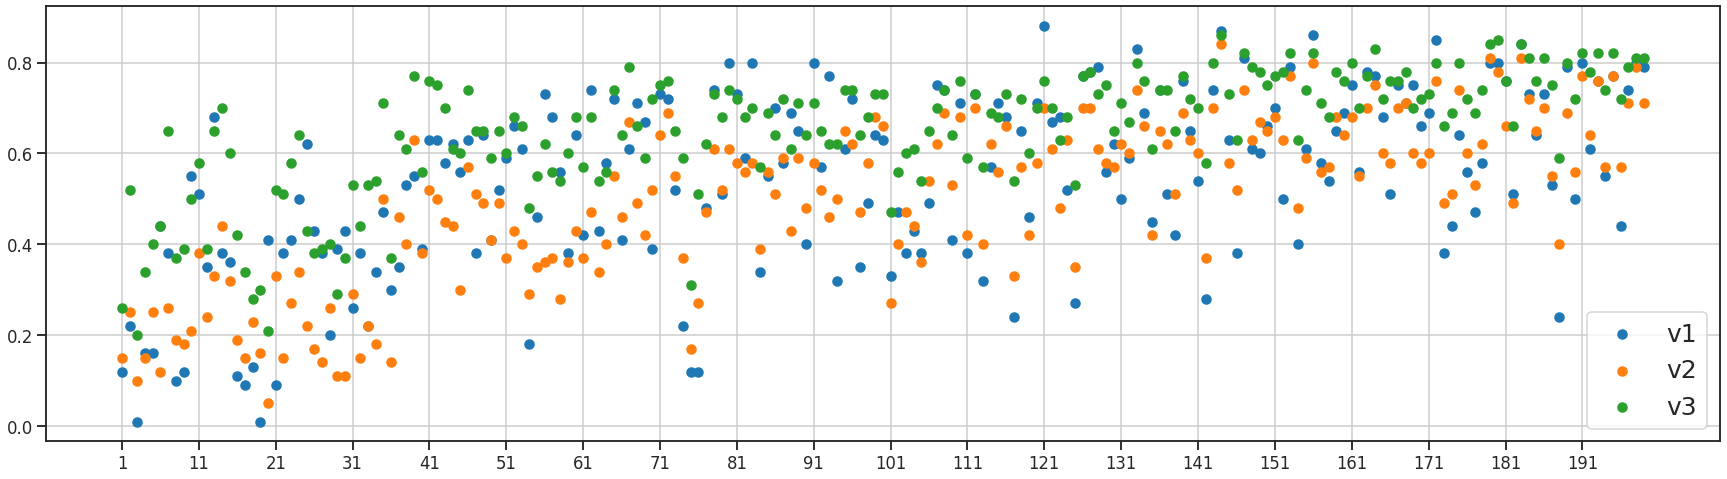

In [15]:
plot_Overlapping("MFs/models_MY_lr_5e-5_U_test1.txt")

## For QU maps, train on small patches, test on full-sky

In [82]:
Thr_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin_348.npy')[0]

Ls_U = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_U20amin.npy')[1]
Ls_U_rescaled = np.zeros_like(Ls_U)
for i in range(Ls_U.shape[0]):
        
        Ls_U_rescaled[i] = rescale_min_max(Ls_U[i])

Ls_U_rescaled = Ls_U_rescaled.reshape((Ls_U.shape[0], Ls_U.shape[1], Ls_U.shape[1], 1)) 

In [75]:
Thr_Q = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin_348.npy')[0]

Ls_Q = np.load('/pscratch/sd/j/jianyao/forse_output/training_data_Nico_T12amin_Q20amin.npy')[1]
Ls_Q_rescaled = np.zeros_like(Ls_Q)
for i in range(Ls_Q.shape[0]):
        
        Ls_Q_rescaled[i] = rescale_min_max(Ls_Q[i])

Ls_Q_rescaled = Ls_Q_rescaled.reshape((Ls_Q.shape[0], Ls_Q.shape[1], Ls_Q.shape[1], 1)) 

In [10]:
Thr_U.shape

(348, 320, 320)

In [11]:
Ls_U_rescaled.shape

(8526, 320, 320, 1)

In [83]:
# dirs = '/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/'

# rhos_t, f_t, u_t, chi_t = [], [], [], []
# npatches = 174
# for i in range(0,348):

#     mT = rescale_min_max(Thr_U[i], return_min_max=False)
#     rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    
#     f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

# f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)


# checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-%s'%53)
# checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/3_arcmin_348_models_MY_lr_5e-5_Q_jupyter/training_checkpoints/ckpt-%s'%82)

checkpoint.restore('/pscratch/sd/j/jianyao/forse_output/3_arcmin_8000_models_MY_lr_5e-5_U_jupyter/training_checkpoints/ckpt-%s'%296)
NNout_Q = generator.predict(Ls_U_rescaled)

In [90]:
del Ls_U_rescaled
del Ls_U
del Thr_U

In [78]:
NNout_Q.shape

(8526, 320, 320, 1)

In [84]:
# np.save('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Qout_3amin_Nico_20amin_model_from_5_6.npy', NNout_Q)

np.save('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Uout_3amin_Nico_20amin_model_from_full_sky.npy', NNout_Q)

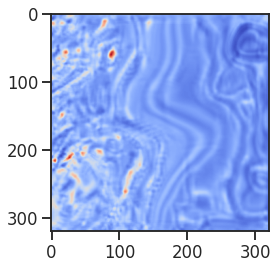

In [88]:
plt.imshow(NNout_Q[2000])

In [91]:
NNout_Q_reshape = NNout_Q.reshape(174, 49, 320, 320, 1)

In [92]:
NNout_Q_reshape.shape

(174, 49, 320, 320, 1)

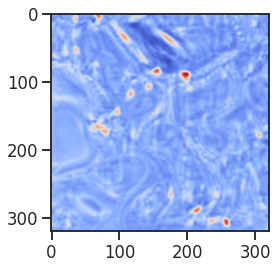

In [94]:
plt.imshow(NNout_Q_reshape[33, 4])

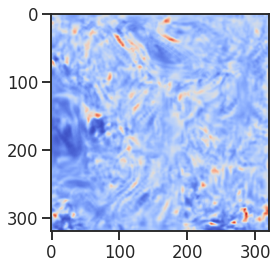

In [95]:
plt.imshow(maps_out_3U[33, 4])

In [16]:
with open("MFs/3_amin_train_on_8000_test_on_full_sky.txt", "a") as o:
    
    for k in range(0, 25):
        
        rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
        
        print(k)
        if k == 0:
            i_s = 0; i_e = 1
        else:
            i_s = k*2 - 1; i_e = (k+1)*2 - 1
            
        for j in range(174):
            for i in range(i_s, i_e):

                mNN = rescale_min_max(NNout_Q_reshape[j,i,:,:,0], return_min_max=False)
                rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)

                f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

        f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

        m1_nnq = compute_intersection(rhos_T, 
                         [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                         [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                         npt=100000)
        m2_nnq = compute_intersection(rhos_T, 
                             [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                             [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                             npt=100000)
        m3_nnq = compute_intersection(rhos_T, 
                             [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                             [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                             npt=100000)

        o.write('%d %.2f %.2f %.2f\n'%(k, m1_nnq, m2_nnq, m3_nnq))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


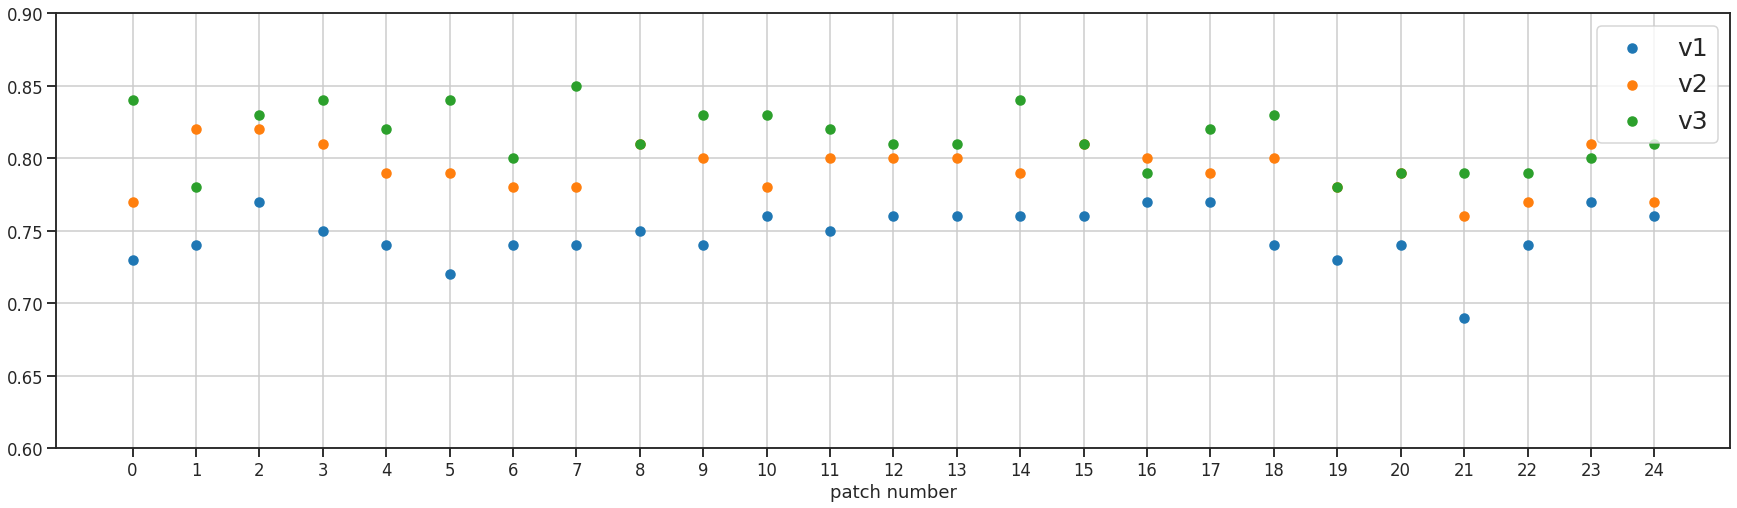

In [20]:
data = np.loadtxt('MFs/3_amin_train_on_348_test_on_full_sky.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(0, 25)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(0, 25, 1))
plt.ylim(0.6, 0.9)
plt.xlabel('patch number')
plt.grid()

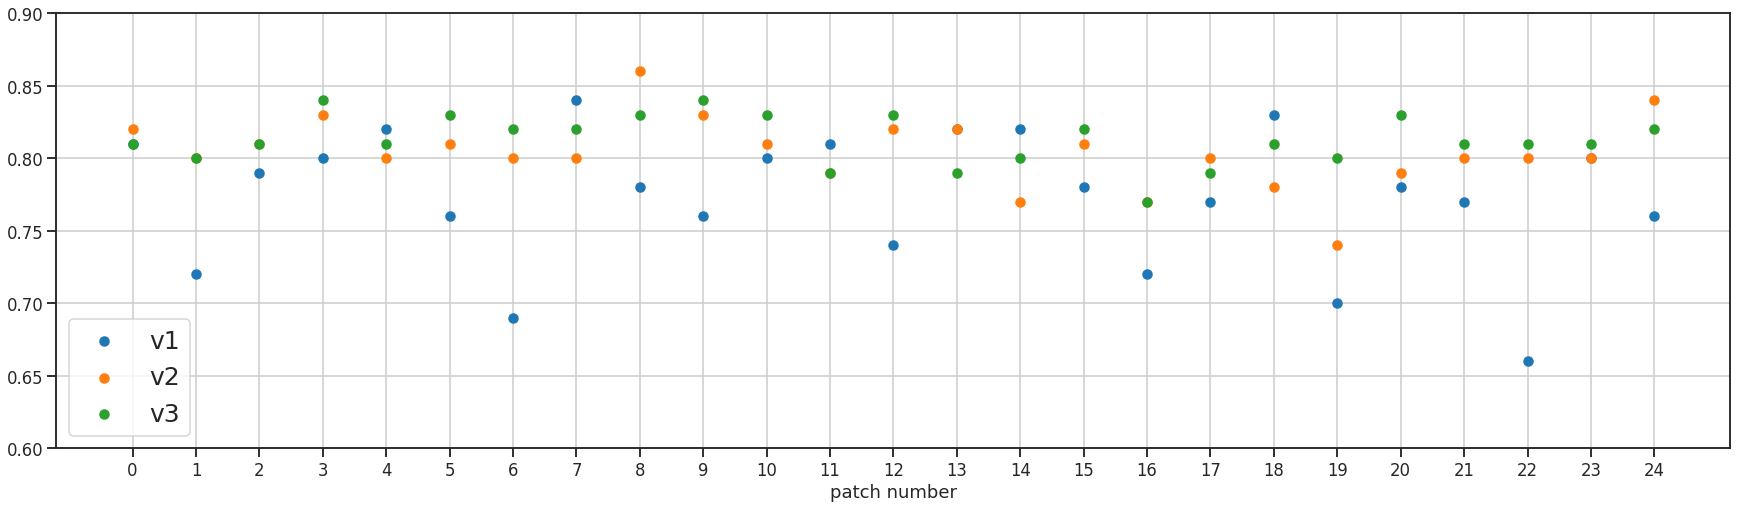

In [21]:
data = np.loadtxt('MFs/3_amin_train_on_8000_test_on_full_sky.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(0, 25)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.ylim(0.6, 0.9)
plt.xticks(np.arange(0, 25, 1))
plt.xlabel('patch number')
plt.grid()

# Units normalization

Input: 
- QU small scales at 3' only, from NN
- Gaussian small scales at 3'  (SS_3'/ SS_20')

## load Gaussian small scales statistics to be the normalization target

In [28]:
Gauss_Q_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_Q.npz')['patches']*1e6 # 174*1280*1280
Gauss_U_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_U.npz')['patches']*1e6

In [29]:
Gauss_Q_20amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_20amin_4096_Q.npz')['patches']*1e6 # 174*1280*1280
Gauss_U_20amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_20amin_4096_U.npz')['patches']*1e6

In [31]:
def divide_patches(Q_12, U_12):
    
    sub_patches_Q = np.zeros([174,49,320,320]); sub_patches_U = np.zeros([174,49,320,320])
    
    for i in range(174):
        for j in range(0,1120,160):
            for k in range(0,1120,160):
                sub_patches_Q[i,int(j/160)*7+int(k/160),:,:] = Q_12[i,j:(j+320),k:(k+320)]
                sub_patches_U[i,int(j/160)*7+int(k/160),:,:] = U_12[i,j:(j+320),k:(k+320)]
    
    return sub_patches_Q, sub_patches_U

In [30]:
Ss_gauss_Q = Gauss_Q_3amin/Gauss_Q_20amin
Ss_gauss_U = Gauss_U_3amin/Gauss_U_20amin

sub_patches_gaussQ, sub_patches_gaussU = divide_patches(Ss_gauss_Q, Ss_gauss_U)

In [21]:
Ss_gauss_mean_Q = np.mean(sub_patches_gaussQ, axis = (2,3))
Ss_gauss_mean_U = np.mean(sub_patches_gaussU, axis = (2,3))

Ss_gauss_std_Q = np.std(sub_patches_gaussQ, axis = (2,3))
Ss_gauss_std_U = np.std(sub_patches_gaussU, axis = (2,3))

In [22]:
Ss_gauss_mean_Q.shape

(174, 49)

In [26]:
Ss_gauss_Q.shape

(174, 1280, 1280)

In [23]:
ss_gauss_mean_std = np.array((Ss_gauss_mean_Q, Ss_gauss_std_Q, Ss_gauss_mean_U, Ss_gauss_std_U))

In [24]:
ss_gauss_mean_std.shape

(4, 174, 49)

In [25]:
np.save('/pscratch/sd/j/jianyao/forse_output/gauss_small_scales_3_over_20_mean_and_std.npy', ss_gauss_mean_std )

In [32]:
Lx = np.radians(20.)
Ly = np.radians(20.)
Nx = 320
Ny = 320

mask = np.ones((320, 320)).flatten()
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny
mask[np.where(xarr.flatten() < Lx / 100.)] = 0
mask[np.where(xarr.flatten() > 99 * Lx / 100.)] = 0
mask[np.where(yarr.flatten() < Ly / 100.)] = 0
mask[np.where(yarr.flatten() > 99 * Ly / 100.)] = 0
mask = mask.reshape([Ny, Nx])
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=2., apotype="C1")

l0_bins = np.arange(20, 1000, 40)
lf_bins = np.arange(20, 1000, 40)+39
b = nmt.NmtBinFlat(l0_bins, lf_bins)
ells_uncoupled = b.get_effective_ells()

f_SSQ = nmt.NmtFieldFlat(Lx, Ly, mask, [np.zeros((320, 320))])
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f_SSQ, f_SSQ, b)

cl_ss_Q = np.ones((174, 49, 1, 25))
cl_ss_U = np.ones((174, 49, 1, 25))

for i in range(0, 174):
    for j in range(49):
        f_SSQ = nmt.NmtFieldFlat(Lx, Ly, mask, [sub_patches_gaussQ [i, j]])
        cl_SS_coupledQ = nmt.compute_coupled_cell_flat(f_SSQ, f_SSQ, b)
        cl_ss_Q[i, j] = w00.decouple_cell(cl_SS_coupledQ)
        f_SSU = nmt.NmtFieldFlat(Lx, Ly, mask, [sub_patches_gaussU[i, j]])
        cl_SS_coupledU = nmt.compute_coupled_cell_flat(f_SSU, f_SSU, b)
        cl_ss_U[i, j] = w00.decouple_cell(cl_SS_coupledU)

In [33]:
np.save('/pscratch/sd/j/jianyao/forse_output/gauss_small_scales_3_over_20_power_spectra.npy', np.array((cl_ss_Q, cl_ss_U)))

In [37]:
gauss_ss_ps.shape

(2, 174, 49, 1, 25)

## load NN small scales and renormalize

$$
\tilde{m}_{S S}^{g e n} \longrightarrow\left(\tilde{m}_{S S}^{g e n}-\left\langle\tilde{m}_{S S}^{\text {gen }}\right\rangle\right) \cdot \frac{S T D\left(\tilde{m}_{S S}^{\text {gauss }}\right)}{S T D\left(\tilde{m}_{S S}^{\text {gen }}\right)}+\left\langle\tilde{m}_{S S}^{\text {gauss }}\right\rangle
$$

$$ \tilde{m}_{S S}^{Q / U} \longrightarrow\left(\tilde{m}_{S S}^{Q / U}-\left\langle\tilde{m}_{S S}^{Q / U}\right\rangle\right) \cdot \sqrt{\frac{\left\langle C_{\ell}^{g a u s s}\right\rangle_{\ell>160}}{\left\langle C_{\ell}^{Q / U}\right\rangle_{\ell>160}}}+\left\langle\tilde{m}_{S S}^{g a u s s}\right\rangle $$

In [8]:
gauss_ss_ps = np.load('/pscratch/sd/j/jianyao/forse_output/gauss_small_scales_3_over_20_power_spectra.npy') #[2, 174, 49, 1, 25] Q, U
gauss_ss_mean_std = np.load('/pscratch/sd/j/jianyao/forse_output/gauss_small_scales_3_over_20_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

In [8]:
maps_out_3Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Qout_3amin_Nico_20amin_model_from_5_6.npy') 
maps_out_3U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Uout_3amin_Nico_20amin_model_from_5_6.npy')
print('out_3Q', maps_out_3Q.shape)
maps_out_3Q = maps_out_3Q.reshape(174,49,320,320)
maps_out_3U = maps_out_3U.reshape(174,49,320,320)
print('out_3Q', maps_out_3Q.shape)

out_3Q (8526, 320, 320, 1)
out_3Q (174, 49, 320, 320)


In [62]:
Nico_20amin_Q = np.load('/pscratch/sd/j/jianyao/forse_output/Nico_Q_20amin.npy')
Nico_20amin_U = np.load('/pscratch/sd/j/jianyao/forse_output/Nico_U_20amin.npy')
print('20Q', Nico_20amin_Q.shape)
Nico_20amin_Q  = Nico_20amin_Q.reshape(174,49,320,320)
Nico_20amin_U  = Nico_20amin_U.reshape(174,49,320,320)
print('20Q', Nico_20amin_Q.shape)

20Q (8526, 320, 320)
20Q (174, 49, 320, 320)


In [15]:
def first_normalization():

    for i in range(174):
        for j in range(49):
            maps_out_3Q[i, j] = (maps_out_3Q[i, j] - np.mean(maps_out_3Q[i, j]))/np.std(maps_out_3Q[i, j])*gauss_ss_mean_std[1][i, j] + gauss_ss_mean_std[0][i, j]
            maps_out_3U[i, j] = (maps_out_3U[i, j] - np.mean(maps_out_3U[i, j]))/np.std(maps_out_3U[i, j])*gauss_ss_mean_std[3][i, j] + gauss_ss_mean_std[2][i, j]
   
    return maps_out_3Q, maps_out_3U

def second_normalization():

    Lx = np.radians(20.)
    Ly = np.radians(20.)
    Nx = 320
    Ny = 320

    mask = np.load('mask_320*320.npy')

    l0_bins = np.arange(20, 1000, 40)
    lf_bins = np.arange(20, 1000, 40)+39
    b = nmt.NmtBinFlat(l0_bins, lf_bins)
    ells_uncoupled = b.get_effective_ells()

    f_SSQ = nmt.NmtFieldFlat(Lx, Ly, mask, [np.zeros((320, 320))])
    w00 = nmt.NmtWorkspaceFlat()
    w00.compute_coupling_matrix(f_SSQ, f_SSQ, b)

    NNmapQ_corr = np.ones((174, 49, 320, 320))
    NNmapU_corr = np.ones((174, 49, 320, 320))

    for i in range(0, 174):
        for j in range(49):
           
            f_NNQ = nmt.NmtFieldFlat(Lx, Ly, mask, [maps_out_3Q[i, j]])
            cl_NN_coupledQ = nmt.compute_coupled_cell_flat(f_NNQ, f_NNQ, b)
            cl_NN_uncoupledQ = w00.decouple_cell(cl_NN_coupledQ)
            f_NNU = nmt.NmtFieldFlat(Lx, Ly, mask, [maps_out_3U[i, j]])
            cl_NN_coupledU = nmt.compute_coupled_cell_flat(f_NNU, f_NNU, b)
            cl_NN_uncoupledU = w00.decouple_cell(cl_NN_coupledU)

            NNmapQ_corr[i,j]=((maps_out_3Q[i,j]-np.mean(maps_out_3Q[i,j]))/np.sqrt(np.mean(cl_NN_uncoupledQ[0][4:]/gauss_ss_ps[0,i,j][0][4:]))+ gauss_ss_mean_std[0][i, j])*Nico_20amin_Q[i, j] 
            NNmapU_corr[i,j]=((maps_out_3U[i,j]-np.mean(maps_out_3U[i,j]))/np.sqrt(np.mean(cl_NN_uncoupledU[0][4:]/gauss_ss_ps[1,i,j][0][4:]))+ gauss_ss_mean_std[2][i, j])*Nico_20amin_U[i, j]
    return NNmapQ_corr, NNmapU_corr

In [16]:
maps_out_3Q, maps_out_3U = first_normalization()
NNmapQ_corr, NNmapU_corr = second_normalization()

In [54]:
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units.npy', NNmapQ_corr)
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_from_20amin_physical_units.npy', NNmapU_corr)

In [17]:
NNmapQ_corr.shape

(174, 49, 320, 320)

## map visuallization

In [65]:
NNmapQ_corr = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units.npy')
NNmapU_corr = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_from_20amin_physical_units.npy')

In [69]:
def plot_maps(Nico_20amin, maps_out_3, NNmap_corr,m = 36, n = 4):
    
    '''
    map visualization; maps at 20 amin; output from NN; renormalize the NN output and combine with the large scales
    m: sky_position. 0-174
    n: patch_position in the 7*7 square
    '''
    fig, axes = plt.subplots(5, 3, figsize = (20, 28))
    
    for l in range(5):
        axes[l][0].imshow(Nico_20amin[m+l, n])
        axes[l][1].imshow(maps_out_3[m+l, n])
        axes[l][2].imshow(NNmap_corr[m+l, n])

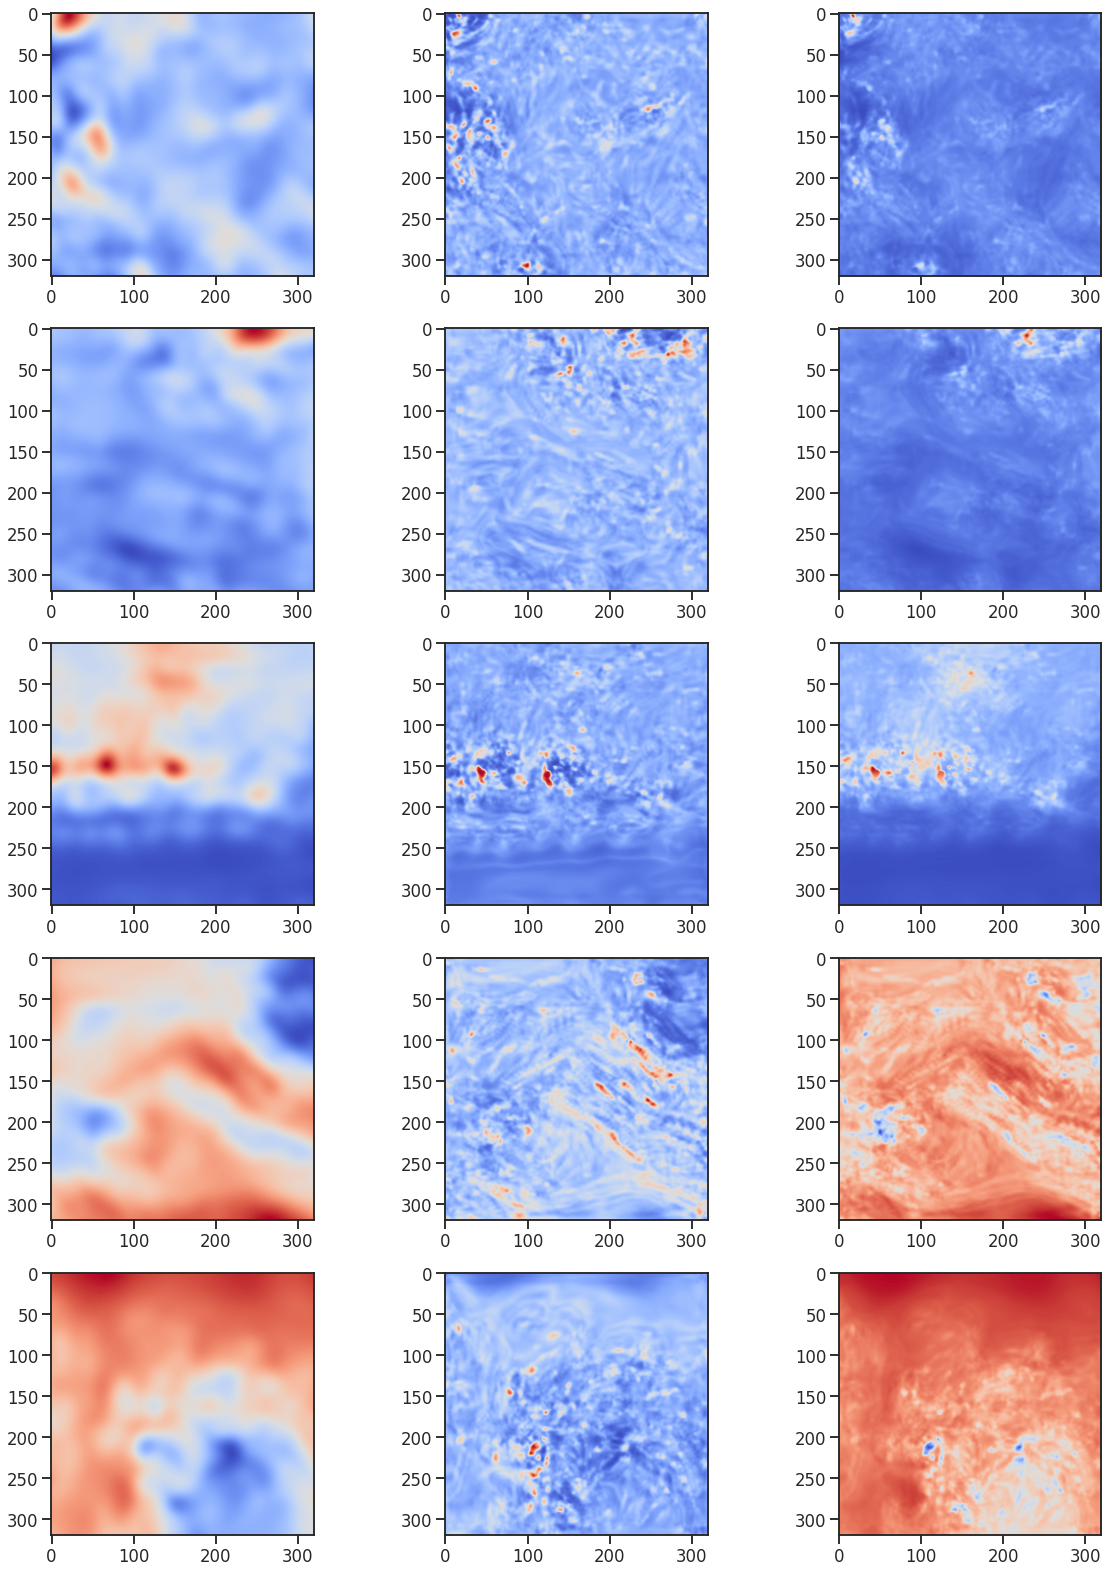

In [70]:
plot_maps(Nico_20amin_Q, maps_out_3Q, NNmapQ_corr,m = 36, n = 4)

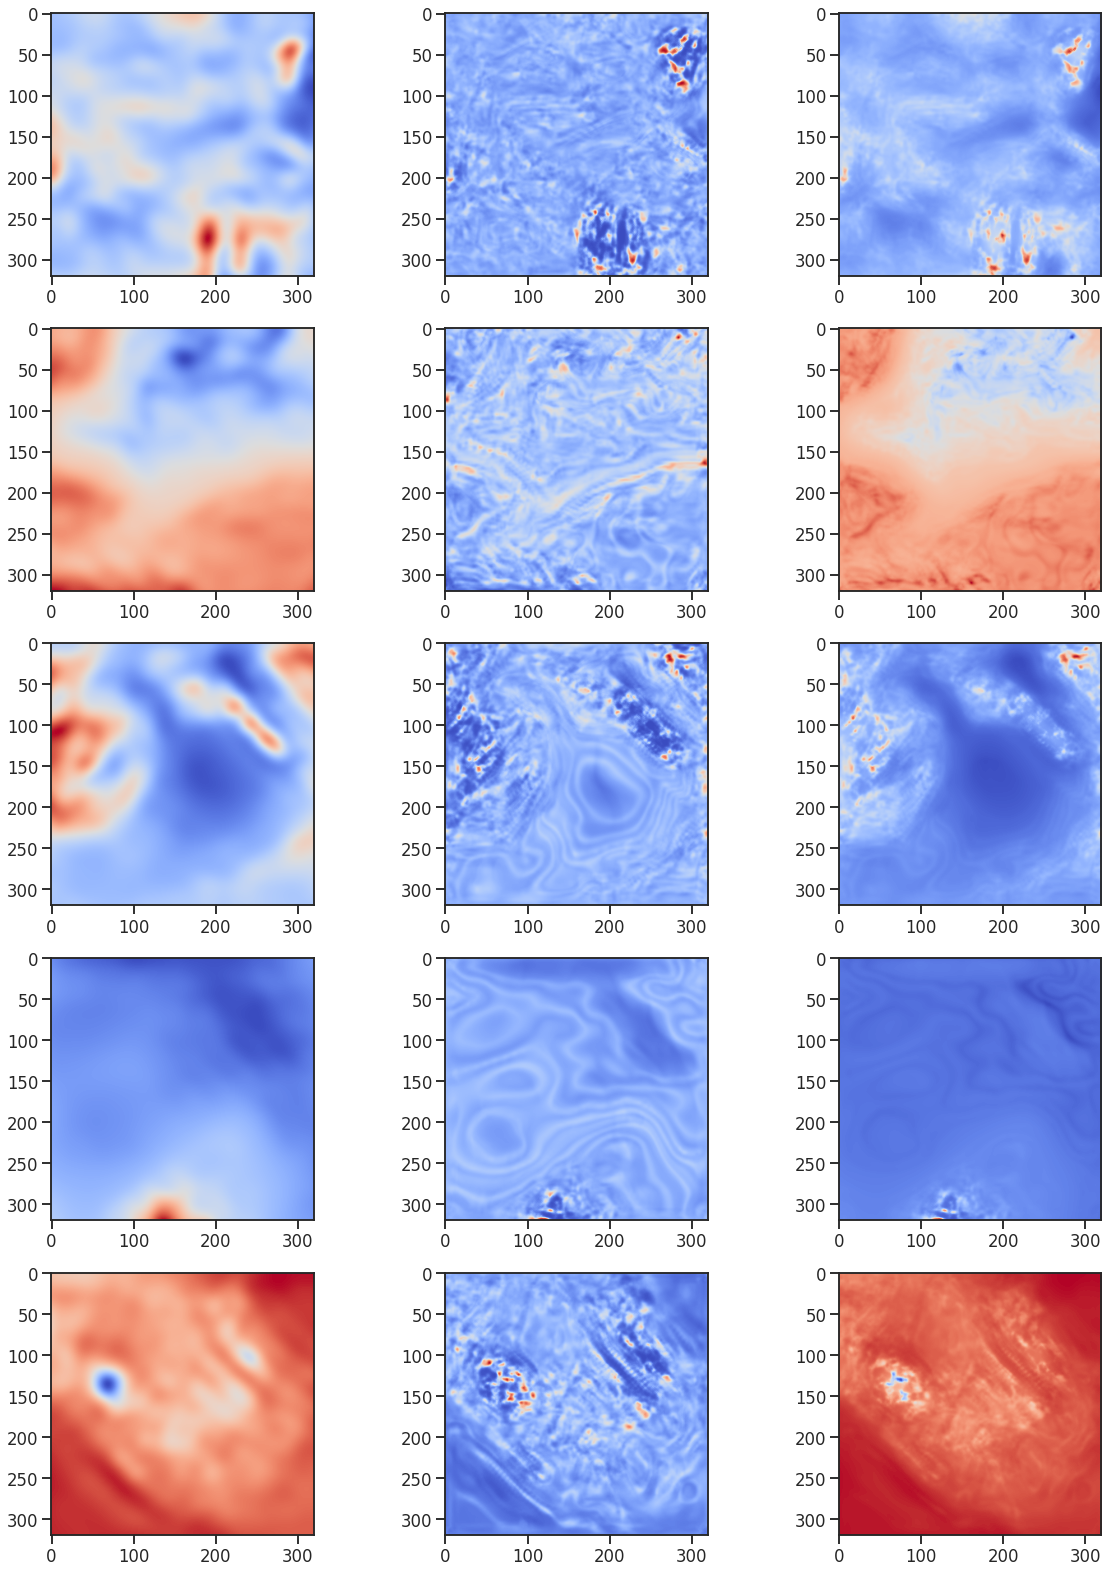

In [71]:
plot_maps(Nico_20amin_U, maps_out_3U, NNmapU_corr,m = 36, n = 4)

## MFs 

In [9]:
dir_data = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/'
Thr = np.load(dir_data+'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0]

In [29]:
def get_one_MF(Thr, NNout, patch_N):
    '''
    calculate MFs of generated NN small scales and overlapping with Intensity small scales 
    '''
    rhos_t, f_t, u_t, chi_t = [], [], [], []
    npatches = 348
    for i in range(0,npatches):

        mT = rescale_min_max(Thr[i], return_min_max=False)
        rhos_T, f_T, u_T, chi_T= get_functionals(mT)

        f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)

    f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)

    rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
    
    if patch_N == 0:  ## use two sets of patches (each has 174 patches) to compare with Intensity 348 maps, except for patch_N = 0, which only has 1 set
        i_s = 0; i_e = 1
    else:
        i_s = patch_N*2 - 1; i_e = (patch_N+1)*2 - 1
        
    for i in range(0,174):
        for j in range(i_s, i_e):
            mNN = rescale_min_max(NNout[i,j,:,:], return_min_max=False)
            rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)
            f_nn.append(f_NN); u_nn.append(u_NN);chi_nn.append(chi_NN); 

    f_nn = np.array(f_nn); u_nn = np.array(u_nn); chi_nn = np.array(chi_nn); 

    m1_nnq = compute_intersection(rhos_T, 
                     [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                     [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], npt=100000)
    m2_nnq = compute_intersection(rhos_T, 
                         [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                         [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], npt=100000)
    m3_nnq = compute_intersection(rhos_T, 
                         [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                         [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], npt=100000)
    
    return m1_nnq, m2_nnq, m3_nnq, rhos_T, f_t, u_t, chi_t, f_nn, u_nn, chi_nn

In [30]:
resultsQ = get_one_MF(Thr, maps_out_3Q, patch_N=3)
resultsU = get_one_MF(Thr, maps_out_3U, patch_N=3)

In [59]:
def plot_MF(results, S):
    rhos_Y, f_t, u_t, chi_t, f_nn, u_nn, chi_nn = results[3:] 
    fig, axes = plt.subplots(1,3, figsize=(24, 4))

    for i in range(3):
        f_nn = results[7+i]; f_t = results[4+i]
        axes[i].fill_between(rhos_Y, 
                             np.mean(f_nn, axis=0)-np.std(f_nn, axis=0), 
                             np.mean(f_nn, axis=0)+np.std(f_nn, axis=0), 
                             lw=1, label=r'$m_{ss}^{NN, %s}$'%S, alpha=0.5, color='#F87217')
        axes[i].plot(rhos_Y, np.mean(f_nn, axis=0), lw=3, ls='--', color='#D04A00')
        axes[i].fill_between(rhos_Y, 
                             np.mean(f_t, axis=0)-np.std(f_t, axis=0), 
                             np.mean(f_t, axis=0)+np.std(f_t, axis=0), 
                             lw=2, label = r'$m_{ss}^{real, I}$', edgecolor='black', facecolor='None')
        axes[i].plot(rhos_Y, np.mean(f_t, axis=0), lw=2, ls='--', color='black')
        
        axes[i].set_xlabel(r'$\rho$', fontsize=20)
        axes[i].set_ylabel(r'$\mathcal{V}_{%s}(\rho$) %s'%(i, S), fontsize=20)
        axes[i].set_title('%.2f'%results[i], fontsize = 20)
        if i == 0:
            axes[i].legend(fontsize = 25)

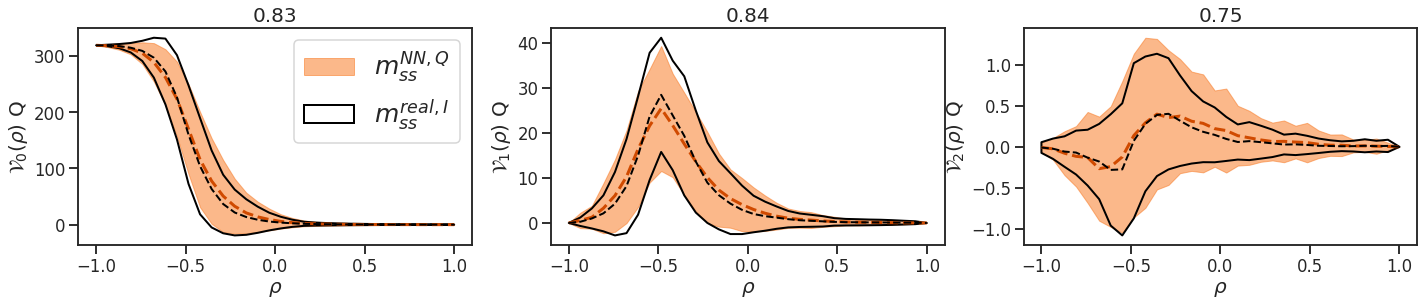

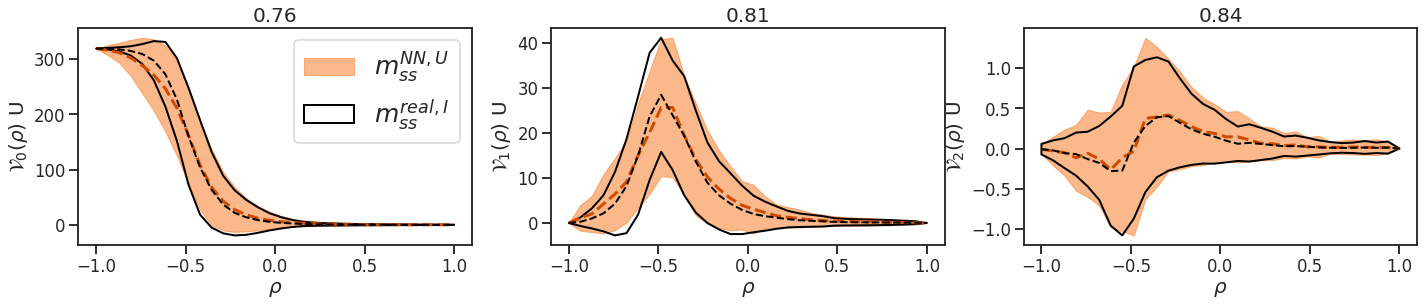

In [73]:
resultsQ = get_one_MF(Thr, maps_out_3Q, patch_N=3)
resultsU = get_one_MF(Thr, maps_out_3U, patch_N=3)
plot_MF(resultsQ, S = 'Q')
plot_MF(resultsU, 'U')

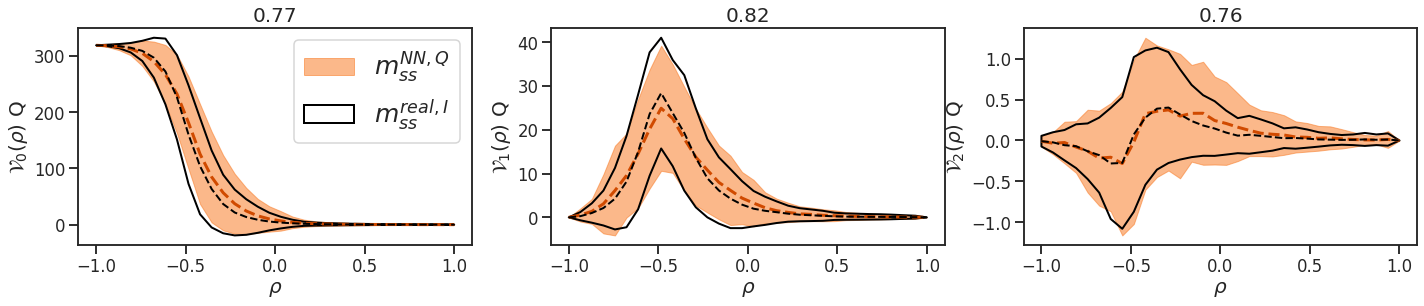

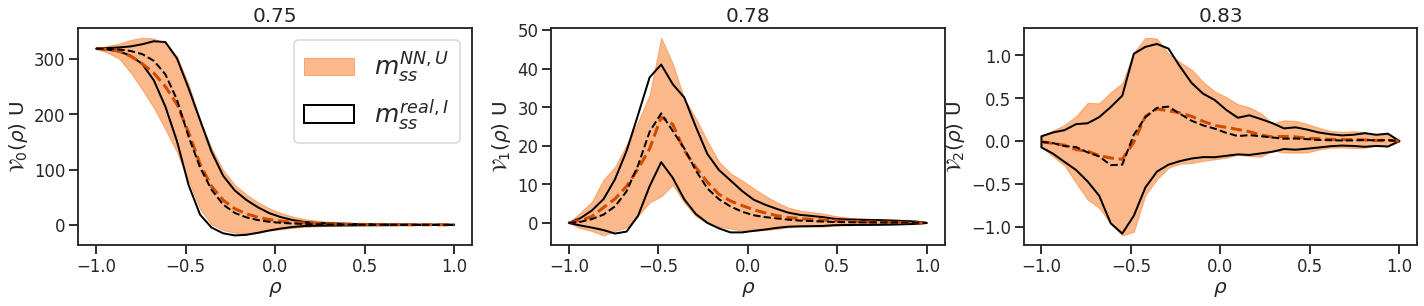

In [72]:
resultsQ = get_one_MF(Thr, maps_out_3Q, patch_N=10)
resultsU = get_one_MF(Thr, maps_out_3U, patch_N=10)
plot_MF(resultsQ, S = 'Q')
plot_MF(resultsU, 'U')

## recompose to full sky map

### 174, 49, 320, 320 (5degx5deg)to 174, 1280, 1280(20degx20deg)

In [28]:
maps_ren2_3Q = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units.npy')
maps_ren2_3U = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_from_20amin_physical_units.npy')

In [108]:
maps_ren2_3Q.shape

(174, 49, 320, 320)

In [2]:
# ========================================================
# Recompose 5°x5° maps together to form 20°x20° maps
# ========================================================
# Create apodization masks
x = np.cos(np.concatenate((np.arange(160)[::-1],np.arange(160)))*np.pi/(2*159))*np.cos(np.concatenate((np.arange(160)[::-1],np.arange(160)))*np.pi/(2*159))
mask_cc = np.zeros((320,320))
for i in range(320):
    for j in range (320):
        mask_cc[i,j] = x[i]*x[j] 

mask_nw = np.copy(mask_cc)
for i in range(160):
    for j in range(160):
        mask_nw[i,j] = 1
for i in range(160):
    for j in range(160,320):
        mask_nw[i,j] = x[j]
for i in range(160,320):
    for j in range(160):
        mask_nw[i,j] = x[i]

mask_sw = np.rot90(mask_nw)
mask_se = np.rot90(mask_sw)
mask_ne = np.rot90(mask_se)

mask_nn = np.copy(mask_cc)
for i in range(160):
    for j in range(320): 
        mask_nn[i,j] = x[j]

mask_ww = np.rot90(mask_nn)
mask_ss = np.rot90(mask_ww)
mask_ee = np.rot90(mask_ss)

In [21]:
# Apply apodization masks to 5°x5° maps
maps_msk_3Q = np.zeros(np.shape(maps_ren2_3Q))
maps_msk_3U = np.zeros(np.shape(maps_ren2_3U))

for i in range(174):  

    # angle masks
    maps_msk_3Q[i,0,:,:] = maps_ren2_3Q[i,0,:,:]*mask_nw
    maps_msk_3Q[i,6,:,:] = maps_ren2_3Q[i,6,:,:]*mask_ne
    maps_msk_3Q[i,42,:,:] = maps_ren2_3Q[i,42,:,:]*mask_sw
    maps_msk_3Q[i,48,:,:] = maps_ren2_3Q[i,48,:,:]*mask_se

    maps_msk_3U[i,0,:,:] = maps_ren2_3U[i,0,:,:]*mask_nw
    maps_msk_3U[i,6,:,:] = maps_ren2_3U[i,6,:,:]*mask_ne
    maps_msk_3U[i,42,:,:] = maps_ren2_3U[i,42,:,:]*mask_sw
    maps_msk_3U[i,48,:,:] = maps_ren2_3U[i,48,:,:]*mask_se

    # side masks
    for j in range(1,6):
        maps_msk_3Q[i,j,:,:] = maps_ren2_3Q[i,j,:,:]*mask_nn
        maps_msk_3U[i,j,:,:] = maps_ren2_3U[i,j,:,:]*mask_nn
    for j in range(43,48):
        maps_msk_3Q[i,j,:,:] = maps_ren2_3Q[i,j,:,:]*mask_ss
        maps_msk_3U[i,j,:,:] = maps_ren2_3U[i,j,:,:]*mask_ss
    for j in [7,14,21,28,35]:
        maps_msk_3Q[i,j,:,:] = maps_ren2_3Q[i,j,:,:]*mask_ww
        maps_msk_3U[i,j,:,:] = maps_ren2_3U[i,j,:,:]*mask_ww
    for j in [13,20,27,34,41]:
        maps_msk_3Q[i,j,:,:] = maps_ren2_3Q[i,j,:,:]*mask_ee
        maps_msk_3U[i,j,:,:] = maps_ren2_3U[i,j,:,:]*mask_ee

    # center masks
    for j in range(8,13):
        maps_msk_3Q[i,j,:,:] = maps_ren2_3Q[i,j,:,:]*mask_cc
        maps_msk_3Q[i,j+7,:,:] = maps_ren2_3Q[i,j+7,:,:]*mask_cc
        maps_msk_3Q[i,j+14,:,:] = maps_ren2_3Q[i,j+14,:,:]*mask_cc
        maps_msk_3Q[i,j+21,:,:] = maps_ren2_3Q[i,j+21,:,:]*mask_cc
        maps_msk_3Q[i,j+28,:,:] = maps_ren2_3Q[i,j+28,:,:]*mask_cc

        maps_msk_3U[i,j,:,:] = maps_ren2_3U[i,j,:,:]*mask_cc
        maps_msk_3U[i,j+7,:,:] = maps_ren2_3U[i,j+7,:,:]*mask_cc
        maps_msk_3U[i,j+14,:,:] = maps_ren2_3U[i,j+14,:,:]*mask_cc
        maps_msk_3U[i,j+21,:,:] = maps_ren2_3U[i,j+21,:,:]*mask_cc
        maps_msk_3U[i,j+28,:,:] = maps_ren2_3U[i,j+28,:,:]*mask_cc


del maps_ren2_3Q
del maps_ren2_3U

# Recompose 20°x20° maps together
maps_big_3Q = np.zeros([174,1280,1280])
maps_big_3U = np.zeros([174,1280,1280])

for i in range(174): 
    for j in range(0,1120,160):
        for k in range(0,1120,160):
            maps_big_3Q[i,j:(j+320),k:(k+320)] += maps_msk_3Q[i,int(j/160)*7+int(k/160),:,:]
            maps_big_3U[i,j:(j+320),k:(k+320)] += maps_msk_3U[i,int(j/160)*7+int(k/160),:,:]

del maps_msk_3Q
del maps_msk_3U



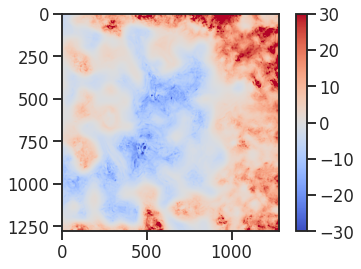

In [54]:
plt.imshow(maps_big_3Q[33], vmin=-30, vmax=30)
# plt.colorbar()

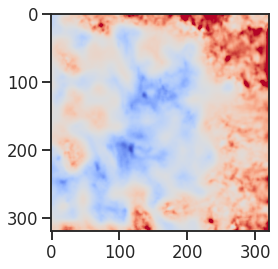

In [53]:
plt.imshow(maps_12amin[33], vmin=-30, vmax=30)
# plt.colorbar()

In [94]:
maps_big_3U.shape

(174, 1280, 1280)

In [107]:
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units_20x20_1280.npy', maps_big_3Q)
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_from_20amin_physical_units_20x20_1280.npy', maps_big_3U)

### 174x1280x1280 to nside=4096

In [116]:
Q_full_sky = hp.read_map('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units_full_sky.fits')

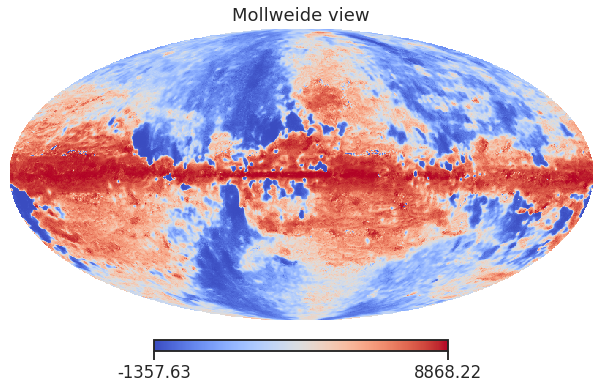

In [118]:
hp.mollview(Q_full_sky, norm = 'hist')

## power spectra

In [83]:
from importlib import reload

In [87]:
import pipeline_evaluation_NN
reload(pipeline_evaluation_NN)
from pipeline_evaluation_NN import *

In [68]:
Gauss_Q_12amin = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_gaussian_ss_Q_20x20deg_Npix320_full_sky_adaptive.npy')*1e6
Gauss_U_12amin = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_gaussian_ss_U_20x20deg_Npix320_full_sky_adaptive.npy')*1e6

In [56]:
Gauss_Q_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_Q.npz')['patches']*1e6 # 174*1280*1280
Gauss_U_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_U.npz')['patches']*1e6

NN_Q_12amin = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_12amin_physical_units.npy')
NN_U_12amin = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_12amin_physical_units.npy')

In [57]:
NN_Q_12amin.shape

(174, 320, 320)

In [90]:
N = 33

Lx = np.radians(20.); Ly = np.radians(20.); Nx = 320; Ny = 320
ell_up, cl_12amin_NN = cl_flat(Lx, Ly, Nx, Ny, NN_Q_12amin[N], NN_U_12amin[N],lmax = 1000, mask = 'mask_320*320.npy', w22_file = "w22_flat_320_320.fits")
ell_up, cl_12amin_Gauss = cl_flat(Lx, Ly, Nx, Ny, Gauss_Q_12amin[N], Gauss_U_12amin[N], lmax = 1000, mask = 'mask_320*320.npy', w22_file = "w22_flat_320_320.fits")

Lx = np.radians(20.); Ly = np.radians(20.); Nx = 1280; Ny = 1280
ell_up_3000, cl_3amin_NN = cl_flat(Lx, Ly, Nx, Ny, maps_big_3Q[N], maps_big_3U[N], lmax = 3000, mask = 'mask_1280*1280.npy', w22_file = "w22_flat_1280_1280_lmax3000.fits")
ell_up_3000, cl_3amin_Gauss = cl_flat(Lx, Ly, Nx, Ny, Gauss_Q_3amin[N], Gauss_U_3amin[N], lmax = 3000, mask = 'mask_1280*1280.npy', w22_file = "w22_flat_1280_1280_lmax3000.fits")

weights loaded from w22_flat_320_320.fits
weights loaded from w22_flat_320_320.fits
weights loaded from w22_flat_1280_1280_lmax3000.fits
weights loaded from w22_flat_1280_1280_lmax3000.fits


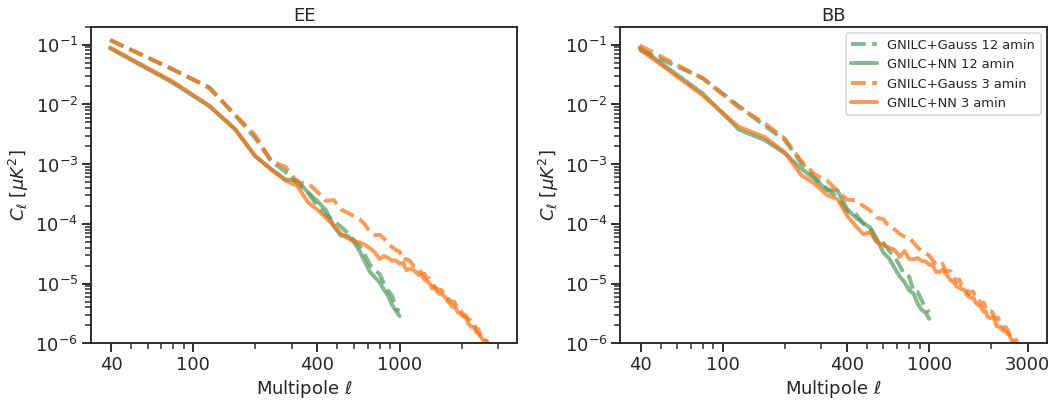

In [92]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
# plt.loglog(ells_uncoupled, cl_LS_uncoupled[0],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ell_up, cl_12amin_Gauss[0], '--', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up, cl_12amin_NN[0], '-', label='GNILC+NN 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up_3000, cl_3amin_Gauss[0], '--', label='GNILC+Gauss 3 amin', lw=4, color='#F87217', alpha=0.7)
plt.loglog(ell_up_3000, cl_3amin_NN[0], '-', label='GNILC+NN 3 amin', lw=4, color='#F87217', alpha=0.7)

plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.xticks([40, 100, 400, 1000], [40, 100, 400, 1000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('EE', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()

plt.subplot(122)
# plt.loglog(ells_uncoupled, cl_LS_uncoupled[3],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ell_up, cl_12amin_Gauss[3], '--', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up, cl_12amin_NN[3], '-', label='GNILC+NN 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up_3000, cl_3amin_Gauss[3], '--', label='GNILC+Gauss 3 amin', lw=4, color='#F87217', alpha=0.7)
plt.loglog(ell_up_3000, cl_3amin_NN[3], '-', label='GNILC+NN 3 amin', lw=4, color='#F87217', alpha=0.7)
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.legend(fontsize=13)
plt.xticks([40, 100, 400, 1000, 3000], [40, 100, 400, 1000, 3000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('BB', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()

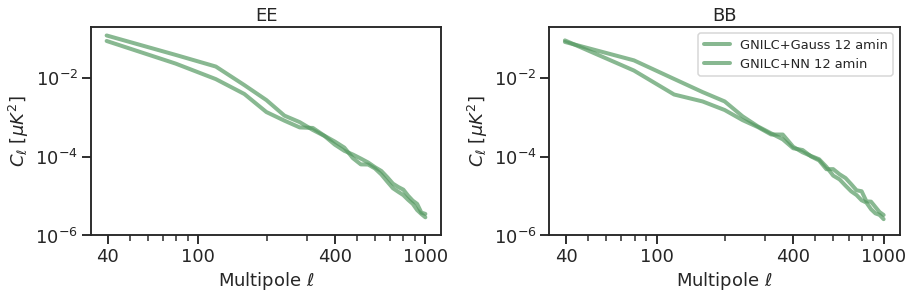

In [120]:
plt.figure(figsize=(13, 4.5))
plt.subplot(121)
# plt.loglog(ells_uncoupled, cl_LS_uncoupled[0],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ell_up, cl_12amin_Gauss[0], '-', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up, cl_12amin_NN[0], '-', label='GNILC+NN 12 amin', lw=4, color='#569A62', alpha=0.7)
# plt.loglog(ell_up_3000, cl_3amin_Gauss[0], '--', label='GNILC+Gauss 3 amin', lw=4, color='#F87217', alpha=0.7)
# plt.loglog(ell_up_3000, cl_3amin_NN[0], '-', label='GNILC+NN 3 amin', lw=4, color='#F87217', alpha=0.7)

plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.xticks([40, 100, 400, 1000], [40, 100, 400, 1000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('EE', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()

plt.subplot(122)
# plt.loglog(ells_uncoupled, cl_LS_uncoupled[3],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ell_up, cl_12amin_Gauss[3], '-', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ell_up, cl_12amin_NN[3], '-', label='GNILC+NN 12 amin', lw=4, color='#569A62', alpha=0.7)
# plt.loglog(ell_up_3000, cl_3amin_Gauss[3], '--', label='GNILC+Gauss 3 amin', lw=4, color='#F87217', alpha=0.7)
# plt.loglog(ell_up_3000, cl_3amin_NN[3], '-', label='GNILC+NN 3 amin', lw=4, color='#F87217', alpha=0.7)
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.legend(fontsize=13)
plt.xticks([40, 100, 400, 1000], [40, 100, 400, 1000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('BB', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()

# generate 12' ss_QU from 80' LS_QU

# comparision between Mine and Nico's generated maps

In [36]:
NN_Nico_Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_Q_bs_16_Nico.npy')
NN_Yao_Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_Q_lr_5e-6_51500.npy')

NN_Nico_U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_bs_16_Nico.npy')
NN_Yao_U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_lr_5e-6_71000.npy')

In [37]:
NN_Yao_Q = NNout_Q

## Plot generated small scales 
Figure 6 in ForSE paper


## compute and plot minkowski functionals 
for both Q and U patches.
Figure 7 in ForSE paper


In [15]:
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_12amin_physical_units.npy', NNmapQ_corr)
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_12amin_physical_units.npy', NNmapU_corr)

#### plot final images
figure 8 in ForSE paper

Nico's results

#### compute polarization power spectra


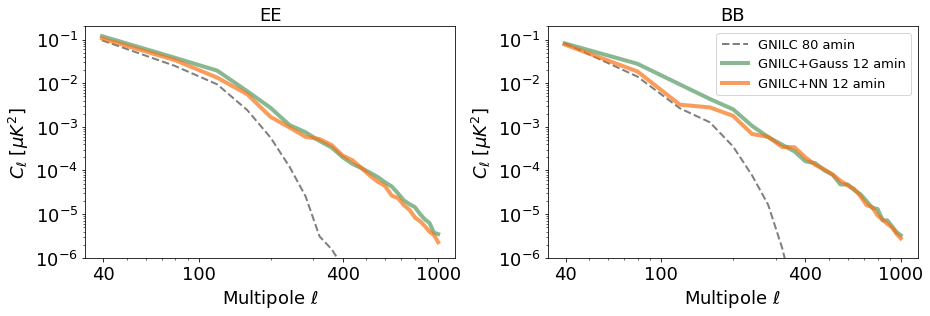

# my_new_Forse

In [4]:
def prepare_small_scales(Ls_Q, Ls_U, Ss_gauss_Q, Ss_gauss_U):
    
    npatches = len(Ls_Q)
    ls_Q = np.zeros_like(Ls_Q); ls_U = np.zeros_like(Ls_Q); ss_gauss_Q = np.zeros_like(Ls_Q); ss_gauss_U = np.zeros_like(Ls_Q)
    ss_gauss_Q_ratio, ss_gauss_U_ratio= Ss_gauss_Q/Ls_Q, Ss_gauss_U/Ls_U # Remove large scales (80') from the gaussian maps, according the definition of ss in the paper
    for i in range(npatches):
        
        ls_Q[i], ls_U[i] = rescale_min_max(Ls_Q[i]), rescale_min_max(Ls_U[i])
        ss_gauss_Q[i], ss_gauss_U[i] = rescale_min_max(ss_gauss_Q_ratio[i]), rescale_min_max(ss_gauss_U_ratio[i])
        
    return ls_Q.reshape((npatches, 320, 320, 1)), ls_U.reshape((npatches, 320, 320, 1)), ss_gauss_Q.reshape((npatches, 320, 320, 1)), ss_gauss_U.reshape((npatches, 320, 320, 1)),ss_gauss_Q_ratio,ss_gauss_U_ratio

dir_data = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/'

Thr, Ls_Q = np.load(dir_data+'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[:, 0:174]
Ls_U = np.load(dir_data+'GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]

Ss_gaussQ = np.load(dir_data+'GNILC_gaussian_ss_Q_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)
Ss_gaussU = np.load(dir_data+'GNILC_gaussian_ss_U_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)

Ls_scaled_Q, Ls_scaled_U, Ss_ratio_scaled_Q, Ss_ratio_scaled_U, Ss_ratio_Q, Ss_ratio_U = prepare_small_scales(Ls_Q, Ls_U, Ss_gaussQ, Ss_gaussU)

In [ ]:
dir_models = '/pscratch/sd/j/jianyao/forse_output/models_MY_lr_5e-5/models/training_checkpoints/'
generator_Q = tf.keras.models.load_model(dir_models+'generat_63000.h5') 
NNout_Q = generator_Q.predict(Ls_scaled_Q)

# generator_U = tf.keras.models.load_model(dir_models+'forse_generator_U.h5')

# generator_U = tf.keras.models.load_model(dir_models+'generat_10500.h5') # have not trained U!!!!!!!!
# NNout_U = generator_U.predict(Ls_scaled_U)

plt.imshow(NNout_Q[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()
# plt.title('NN 12 amin Q')

# generate 3' ss from 12' LS (from 80')

In [78]:
from scipy import ndimage

## load full-map at 12' and small scales at 3'

In [116]:
maps_ren2_12Q = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_12amin_physical_units.npy')
maps_ren2_12U = np.load('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_12amin_physical_units.npy')

In [92]:
maps_ren2_12Q.shape

(174, 320, 320)

In [80]:
maps_out_3Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Qout_3amin_Nico_12amin_my_model.npy')
maps_out_3U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NN_Uout_3amin_Nico_12amin_my_model.npy')

In [81]:
maps_out_3Q.shape

(174, 320, 320, 1)

In [82]:
maps_out_3Q = maps_out_3Q[:,:,:,0]
maps_out_3U = maps_out_3U[:,:,:,0]

In [83]:
maps_out_3Q.shape

(174, 320, 320)

In [84]:
Gauss_Q_12amin = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_gaussian_ss_Q_20x20deg_Npix320_full_sky_adaptive.npy')*1e6 # from K to uK
Gauss_U_12amin = np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_gaussian_ss_U_20x20deg_Npix320_full_sky_adaptive.npy')*1e6

In [85]:
print(Gauss_Q_12amin.shape)

(174, 320, 320)


In [86]:
Gauss_Q_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_Q.npz')['patches']*1e6 # 174*1280*1280
Gauss_U_3amin = np.load('/pscratch/sd/j/jianyao/forse_output/gnilc_map_with_gaussian_3amin_4096_U.npz')['patches']*1e6
print(Gauss_Q_3amin.shape)
Gauss_Q_3amin = ndimage.zoom(Gauss_Q_3amin, [1, 0.25, 0.25])# downsampling to 320*320
Gauss_U_3amin = ndimage.zoom(Gauss_U_3amin, [1, 0.25, 0.25])
print(Gauss_Q_3amin.shape)

(174, 1280, 1280)
(174, 320, 320)


## first normalization

## second normalization

In [121]:
NNmapQ_corr.shape

(174, 320, 320)

In [122]:
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_physical_units.npy', NNmapQ)
np.save('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_physical_units.npy', NNmapU)

In [111]:
Ls_U = (np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)*1e6)[1, 0:174]
Ls_Q = (np.load('/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)*1e6)[1, 0:174]

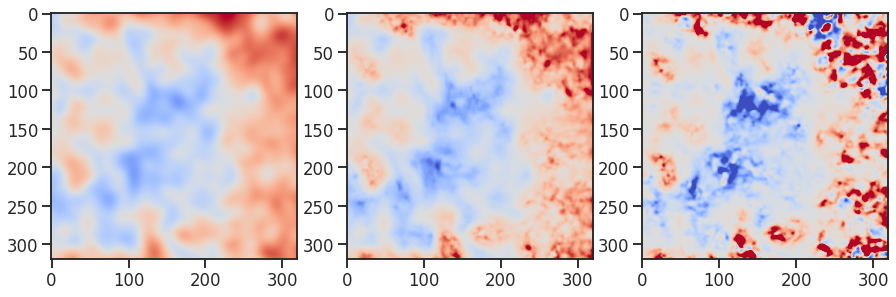

In [120]:
fig, axes = plt.subplots(1,3, figsize = (15, 8))
axes[0].imshow(Ls_Q[33], vmin=-30, vmax=30)
axes[1].imshow(maps_ren2_12Q[33], vmin=-30, vmax=30)
axes[2].imshow(NNmapQ_corr[33], vmin=-30, vmax=30)

## power spectra

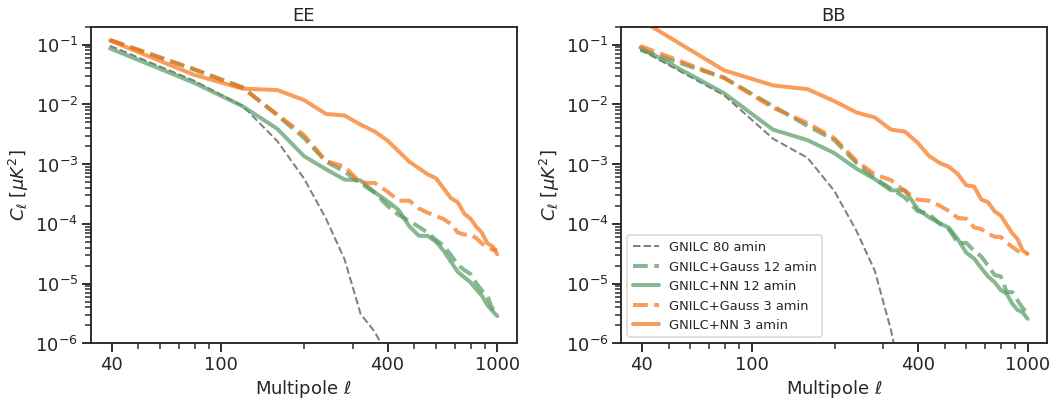